In [1]:
import os
import time
import cv2
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from google.colab import drive
from google.colab import files
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import load_model
from IPython.display import clear_output
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback, CSVLogger
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def dice_coef(y_true, y_pred, smooth=1):
    """ Calcula a sobreposição (Overlap) """
    # Garantir que ambos são float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    # Garante de novo que só tem float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Crossentropy normal
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    # Dice loss
    dice = dice_loss(y_true, y_pred)
    # Soma
    return ce + dice

In [4]:
def tem_nucleo_roxo(imagem_crop):
    hsv = cv2.cvtColor(imagem_crop, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, np.array([100, 40, 40]), np.array([170, 255, 255]))
    return (np.count_nonzero(mask) / mask.size) > 0.05

In [5]:
def smart_crop_centered(image):
    # 1. Garantir formato correto
    if image.dtype != np.uint8:
        image = np.uint8(image)

    # 2. Detetar o Núcleo (Igual a antes)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_purple = np.array([100, 40, 40])
    upper_purple = np.array([170, 255, 255])
    mask = cv2.inRange(hsv, lower_purple, upper_purple)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return preprocess_input(image)

    # Pega no maior núcleo
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)

    # Calcula o centro exato do núcleo
    cx = x + w // 2
    cy = y + h // 2

    # 1. Definir o tamanho do quadrado que queremos cortar, neste caso usou-se 2.5x por tentativa e erro
    max_side = max(w, h)
    crop_size = int(max_side * 2.5)
    half_size = crop_size // 2

    # 2. Adicionamos uma margem igual ao tamanho do crop para nunca faltar espaço e caso seja preciso preencher alguma coisa usa-se o reflect em vez de pintar a preto
    img_padded = cv2.copyMakeBorder(image, crop_size, crop_size, crop_size, crop_size, cv2.BORDER_REFLECT)

    # 3. Ajustar as coordenadas do centro para a nova imagem com margem
    cx_pad = cx + crop_size
    cy_pad = cy + crop_size

    # 4. Agora cortar
    x1 = cx_pad - half_size
    y1 = cy_pad - half_size
    x2 = x1 + crop_size
    y2 = y1 + crop_size

    cropped = img_padded[y1:y2, x1:x2]

    # 5. Redimensionar para o tamanho final da EfficientNet (224)
    cropped = cv2.resize(cropped, (224, 224), interpolation=cv2.INTER_LINEAR)

    return preprocess_input(cropped)

In [6]:
def contar_celulas(mask_argmax):
    """
    Conta células baseada na máscara da U-Net usando Connected Components.
    """
    contagem = {}
    classes = {
        2: "WBC (Glóbulos Brancos)",
        1: "RBC (Glóbulos Vermelhos)",
        3: "Plaquetas"
    }

    for class_id, nome_classe in classes.items():
        # Máscara binária da classe
        mask_temp = np.zeros_like(mask_argmax, dtype=np.uint8)
        mask_temp[mask_argmax == class_id] = 255

        # Retira pontos isolados
        kernel = np.ones((3,3), np.uint8)
        mask_temp = cv2.morphologyEx(mask_temp, cv2.MORPH_OPEN, kernel, iterations=1)

        # Conta o nº de ilhas
        num_labels, _ = cv2.connectedComponents(mask_temp)

        # Desconta o fundo
        contagem[nome_classe] = max(0, num_labels - 1)

    return contagem

In [10]:
# Configurações e Caminhos
PATH_MODELO = '/content/drive/MyDrive/Capstone_project/Dataset/U_net/modelo_sangue_unet4.keras'
PATH_IMAGENS = '/content/drive/MyDrive/Capstone_project/Dataset/U_net/dataset_ready_gui/images'
PATH_MASKS = '/content/drive/MyDrive/Capstone_project/Dataset/U_net/dataset_ready_gui/masks_SAM_2.0/masks_SAM_NOVAS'

IMG_SIZE = (256, 256)
CLASSES = {0: 'Fundo', 1: 'RBC', 2: 'WBC', 3: 'Plaquetas'}

def pos_processamento_wbc(mask_pred, min_pixels=60):
    """Limpa ruído e fecha buracos na segmentação de WBC."""
    mask_pred = mask_pred.astype(np.uint8)

    # Isolar classe WBC
    wbc_bin = (mask_pred == 2).astype(np.uint8) * 255

    # Filtrar componentes por área (remover "falsos positivos" pequenos)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(wbc_bin)
    mask_limpa = np.zeros_like(wbc_bin)

    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_pixels:
            mask_limpa[labels == i] = 255

    # Reconstruir a máscara mantendo as outras classes intactas
    res = mask_pred.copy()
    res[res == 2] = 0
    res[mask_limpa == 255] = 2
    return res

def swap_labels(mask):
    """Ajusta a correspondência de labels entre o Ground Truth e o Modelo."""
    nova = mask.copy()
    nova[mask == 1] = 2  # WBC
    nova[mask == 2] = 1  # RBC
    return nova

# Carregar modelo usando as funções reais (combined_loss, dice_coef) definidas no início
print("A carregar modelo...")
model = load_model(PATH_MODELO, custom_objects={
    'combined_loss': combined_loss,
    'dice_coef': dice_coef
})

# Inicializar métricas
stats = {k: {'reais': 0, 'acertos': 0} for k in CLASSES.keys()}
img_files = [f for f in os.listdir(PATH_IMAGENS) if f.lower().endswith(('.png', '.jpg'))]

print(f"Avaliação iniciada: {len(img_files)} imagens.")

for i, f in enumerate(sorted(img_files)):
    p_mask = os.path.join(PATH_MASKS, f)
    if not os.path.exists(p_mask):
        continue

    # 1. Preprocessamento da imagem
    img = cv2.resize(cv2.imread(os.path.join(PATH_IMAGENS, f)), IMG_SIZE)
    img_batch = np.expand_dims(img.astype(np.float32) / 255.0, axis=0)

    # 2. Preprocessamento da máscara real
    mask_real = cv2.imread(p_mask, cv2.IMREAD_UNCHANGED)
    if len(mask_real.shape) == 3:
        mask_real = mask_real[:, :, 0]
    mask_real = cv2.resize(mask_real, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
    mask_real = swap_labels(mask_real)

    # 3. Inferência e limpeza
    pred = model.predict(img_batch, verbose=0)
    mask_pred = np.argmax(pred[0], axis=-1)
    mask_pred = pos_processamento_wbc(mask_pred)

    # 4. Cálculo de recall por classe
    for cid in CLASSES.keys():
        idx_real = (mask_real == cid)
        total_pixels = np.sum(idx_real)

        if total_pixels > 0:
            stats[cid]['reais'] += total_pixels
            stats[cid]['acertos'] += np.sum(idx_real & (mask_pred == cid))

    if (i + 1) % 50 == 0:
        print(f"Progresso: {i + 1}/{len(img_files)}")

# Exibição dos resultados
print("\n" + "-"*40)
print(f"{'Classe':<15} | {'Recall':<10}")
print("-"*40)

for cid, nome in CLASSES.items():
    s = stats[cid]
    recall = (s['acertos'] / s['reais'] * 100) if s['reais'] > 0 else 0
    print(f"{nome:<15} | {recall:>6.2f}%")

A carregar modelo...
Avaliação iniciada: 1260 imagens.
Progresso: 50/1260
Progresso: 100/1260
Progresso: 150/1260
Progresso: 200/1260
Progresso: 250/1260
Progresso: 300/1260
Progresso: 350/1260
Progresso: 400/1260
Progresso: 450/1260
Progresso: 500/1260
Progresso: 550/1260
Progresso: 600/1260
Progresso: 650/1260
Progresso: 700/1260
Progresso: 750/1260
Progresso: 800/1260
Progresso: 850/1260
Progresso: 900/1260
Progresso: 950/1260
Progresso: 1000/1260
Progresso: 1050/1260
Progresso: 1100/1260
Progresso: 1150/1260
Progresso: 1200/1260
Progresso: 1250/1260

----------------------------------------
Classe          | Recall    
----------------------------------------
Fundo           |  65.66%
RBC             |  97.45%
WBC             |  60.61%
Plaquetas       |  63.00%


Dados prontos. Imagens: 50

A avaliar modelos...
-> UNet_final concluído (Dice WBC: 0.7108)


-> UNet_3 concluído (Dice WBC: 0.9437)


-> UNet_2 concluído (Dice WBC: 0.9168)
-> UNet_1 concluído (Dice WBC: 0.9330)

Ranking por performance (WBC Dice):
    Modelo  WBC Dice  Mean IoU  Tempo (s)
    UNet_3  0.943717  0.789325   2.242234
    UNet_1  0.932963  0.774082   1.860565
    UNet_2  0.916797  0.693758   1.867847
UNet_final  0.710841  0.522697  11.918853


/tmp/ipython-input-495600042.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Modelo', y='WBC Dice', ax=ax[0], palette='magma')
/tmp/ipython-input-495600042.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Modelo', y='Mean IoU', ax=ax[1], palette='viridis')
/tmp/ipython-input-495600042.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Modelo', y='Tempo (s)', ax=ax[2], palette='flare')


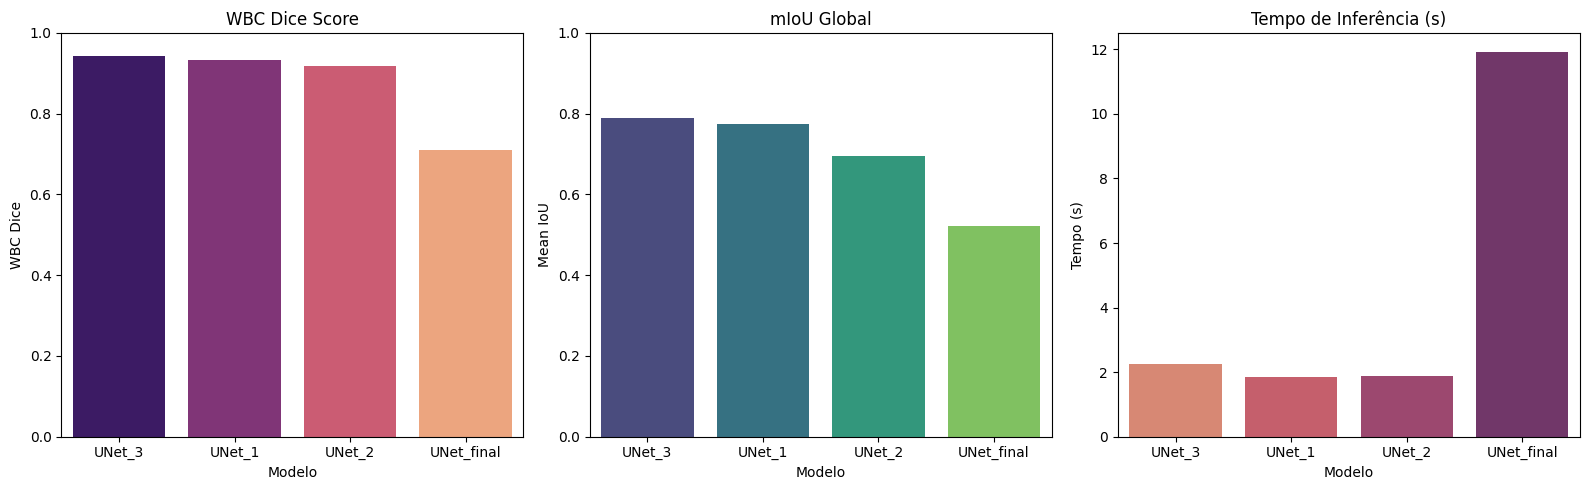

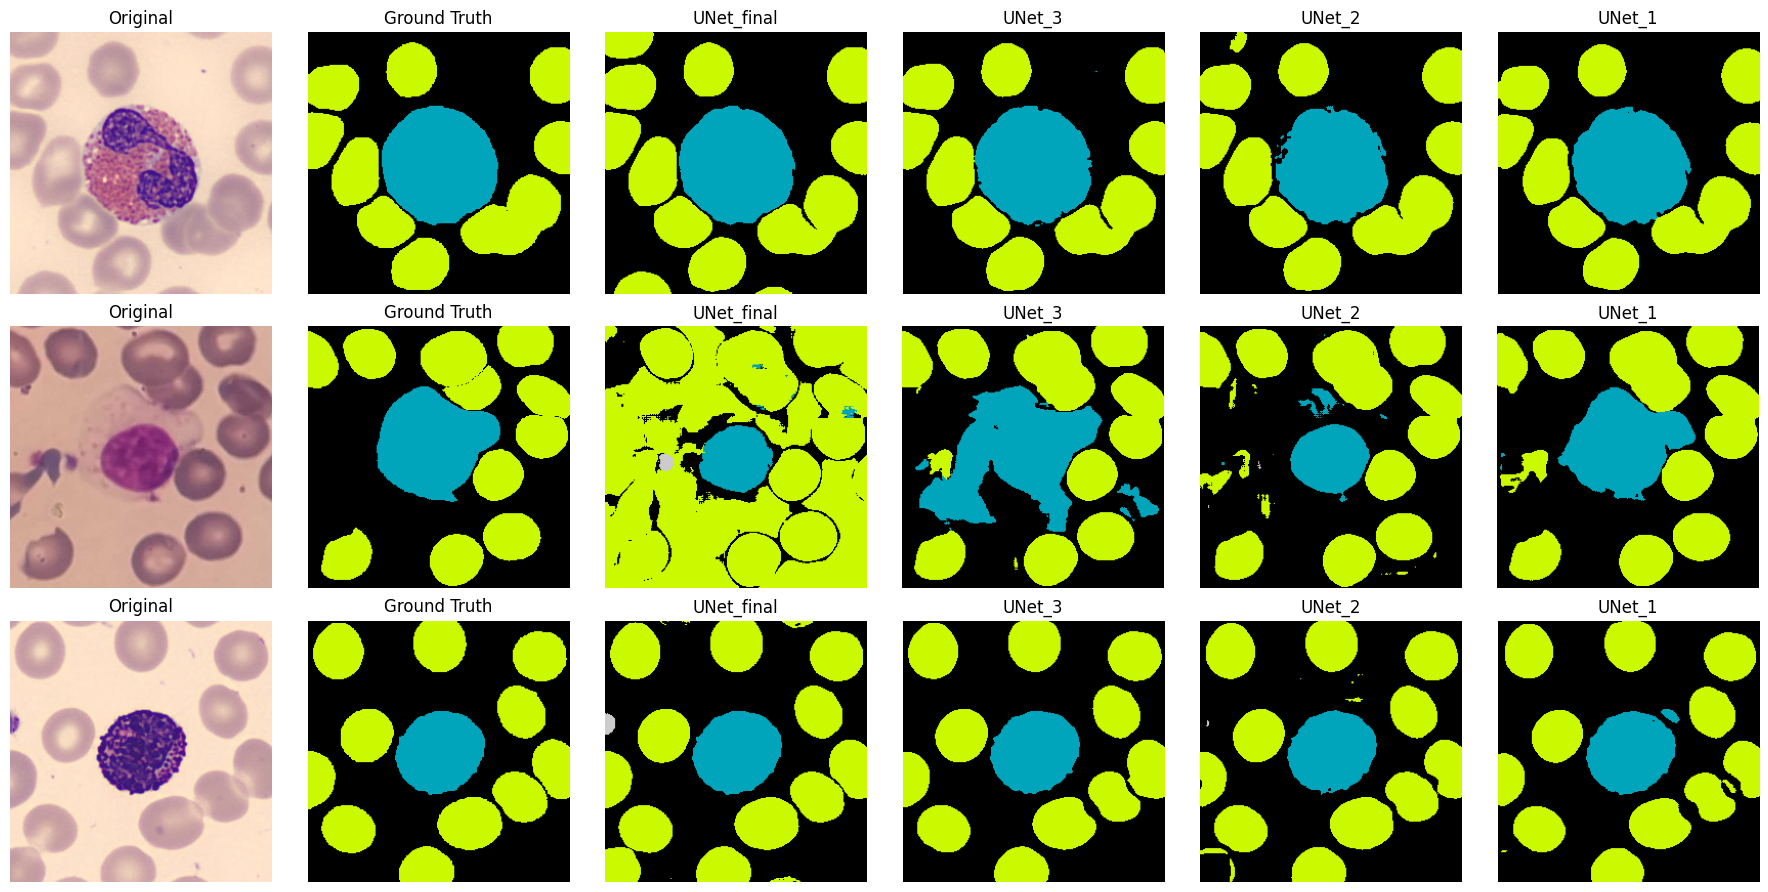

In [11]:
# --- Configurações ---
PATH_IMAGENS = '/content/drive/MyDrive/Capstone_project/Dataset/U_net/dataset_ready_gui/images'
PATH_MASKS = '/content/drive/MyDrive/Capstone_project/Dataset/U_net/dataset_ready_gui/masks_SAM_2.0/masks_SAM_NOVAS'

model_paths = {
    'UNet_final': '/content/drive/MyDrive/Capstone_project/Dataset/U_net/modelo_sangue_unet4.keras',
    'UNet_3':     '/content/drive/MyDrive/Capstone_project/Dataset/U_net/modelo_sangue_unet_sam_2.0.keras',
    'UNet_2':     '/content/drive/MyDrive/Capstone_project/Dataset/U_net/modelo_sangue_unet_sam.keras',
    'UNet_1':     '/content/drive/MyDrive/Capstone_project/Dataset/U_net/modelo_sangue_unet_optimized.keras'
}

IMG_SIZE = (256, 256)
LIMIT = 50
CLASS_NAMES = ['Fundo', 'RBC', 'WBC', 'Plaquetas']

def load_test_data(img_dir, mask_dir, size, limit=None):
    """Carrega e preprocessa um subset para teste rápido."""
    img_names = sorted(os.listdir(img_dir))[:limit]
    mask_names = sorted(os.listdir(mask_dir))[:limit]

    x_data, y_data = [], []

    for img_n, mask_n in zip(img_names, mask_names):
        # Imagem
        img = cv2.imread(os.path.join(img_dir, img_n))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x_data.append(cv2.resize(img, size) / 255.0)

        # Máscara
        mask = cv2.imread(os.path.join(mask_dir, mask_n), cv2.IMREAD_GRAYSCALE)
        y_data.append(cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST))

    return np.array(x_data), np.array(y_data)

def get_metrics(y_true, y_pred, class_id):
    """Calcula IoU e Dice para uma classe específica."""
    true_mask = (y_true == class_id)
    pred_mask = (y_pred == class_id)

    intersection = np.logical_and(true_mask, pred_mask).sum()
    union = np.logical_or(true_mask, pred_mask).sum()

    if union == 0:
        return (1.0, 1.0) if intersection == 0 else (0.0, 0.0)

    iou = intersection / union
    dice = (2. * intersection) / (true_mask.sum() + pred_mask.sum() + 1e-7)
    return iou, dice

# Preparação
X_test, y_test = load_test_data(PATH_IMAGENS, PATH_MASKS, IMG_SIZE, LIMIT)
print(f"Dados prontos. Imagens: {len(X_test)}")

results = []
pred_maps = {}

print("\nA avaliar modelos...")

for name, path in model_paths.items():
    if not os.path.exists(path):
        print(f"Aviso: Modelo {name} não encontrado em {path}")
        continue

    # Carregar e prever
    model = load_model(path, compile=False)
    start = time.time()
    preds = model.predict(X_test, verbose=0)
    inference_time = time.time() - start

    # Ajuste de canais para o modelo final
    if name == 'UNet_final':
        # Swap RBC e WBC
        tmp_wbc = preds[:, :, :, 2].copy()
        preds[:, :, :, 2] = preds[:, :, :, 1]
        preds[:, :, :, 1] = tmp_wbc

    mask_pred = np.argmax(preds, axis=-1)
    pred_maps[name] = mask_pred

    # Métricas
    iou_wbc, dice_wbc = get_metrics(y_test, mask_pred, class_id=2)

    # Média IoU
    mean_iou = np.mean([get_metrics(y_test, mask_pred, c)[0] for c in range(len(CLASS_NAMES))])

    results.append({
        'Modelo': name,
        'WBC Dice': dice_wbc,
        'Mean IoU': mean_iou,
        'Tempo (s)': inference_time
    })

    print(f"-> {name} concluído (Dice WBC: {dice_wbc:.4f})")

    # Limpeza de memória
    del model
    K.clear_session()

# Análise de Resultados
df = pd.DataFrame(results).sort_values('WBC Dice', ascending=False)
print("\nRanking por performance (WBC Dice):")
print(df.to_string(index=False))

# Visualização Gráfica
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

sns.barplot(data=df, x='Modelo', y='WBC Dice', ax=ax[0], palette='magma')
ax[0].set_title('WBC Dice Score')
ax[0].set_ylim(0, 1)

sns.barplot(data=df, x='Modelo', y='Mean IoU', ax=ax[1], palette='viridis')
ax[1].set_title('mIoU Global')
ax[1].set_ylim(0, 1)

sns.barplot(data=df, x='Modelo', y='Tempo (s)', ax=ax[2], palette='flare')
ax[2].set_title('Tempo de Inferência (s)')

plt.tight_layout()
plt.show()

# Comparação Visual
n_samples = 3
samples = np.random.choice(len(X_test), n_samples, replace=False)
n_models = len(pred_maps)

plt.figure(figsize=(3 * (n_models + 2), 3 * n_samples))

for i, idx in enumerate(samples):
    # Original
    plt.subplot(n_samples, n_models + 2, i * (n_models + 2) + 1)
    plt.imshow(X_test[idx])
    plt.title("Original")
    plt.axis('off')

    # Ground Truth
    plt.subplot(n_samples, n_models + 2, i * (n_models + 2) + 2)
    plt.imshow(y_test[idx], cmap='nipy_spectral', vmin=0, vmax=3)
    plt.title("Ground Truth")
    plt.axis('off')

    # Predições dos Modelos
    for j, (m_name, m_pred) in enumerate(pred_maps.items()):
        plt.subplot(n_samples, n_models + 2, i * (n_models + 2) + 3 + j)
        plt.imshow(m_pred[idx], cmap='nipy_spectral', vmin=0, vmax=3)
        plt.title(m_name)
        plt.axis('off')

plt.tight_layout()
plt.show()